# **Deep HW3**

**Pantea Amoie    400101656**

### Q2
#### Part 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np


# -----------------------------
# PART A
# -----------------------------

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Filtering only 'airplane' and 'automobile'
class_subset = [0, 1]  # airplane: 0, automobile: 1
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filtering dataset for required classes
train_idx = [i for i, label in enumerate(trainset.targets) if label in class_subset]
test_idx = [i for i, label in enumerate(testset.targets) if label in class_subset]

trainset.targets = [trainset.targets[i] for i in train_idx]
testset.targets = [testset.targets[i] for i in test_idx]

trainset.data = trainset.data[train_idx]
testset.data = testset.data[test_idx]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# --------------------------------
# PART B
# --------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Modifying FC layers for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in range(epochs):
    train_loss, correct, total = 0, 0, 0
    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Binary labels: converting {0,1} to class indices {0,1}
        labels = torch.tensor(labels).long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]
<ipython-input-6-0a562d1b5a9c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Epoch 1, Loss: 0.1488, Accuracy: 0.9408
Epoch 2, Loss: 0.0851, Accuracy: 0.9679
Epoch 3, Loss: 0.0575, Accuracy: 0.9790
Epoch 4, Loss: 0.0586, Accuracy: 0.9775
Epoch 5, Loss: 0.0437, Accuracy: 0.9835
Epoch 6, Loss: 0.0444, Accuracy: 0.9828
Epoch 7, Loss: 0.0260, Accuracy: 0.9912
Epoch 8, Loss: 0.0376, Accuracy: 0.9861
Epoch 9, Loss: 0.0332, Accuracy: 0.9878
Epoch 10, Loss: 0.0372, Accuracy: 0.9851


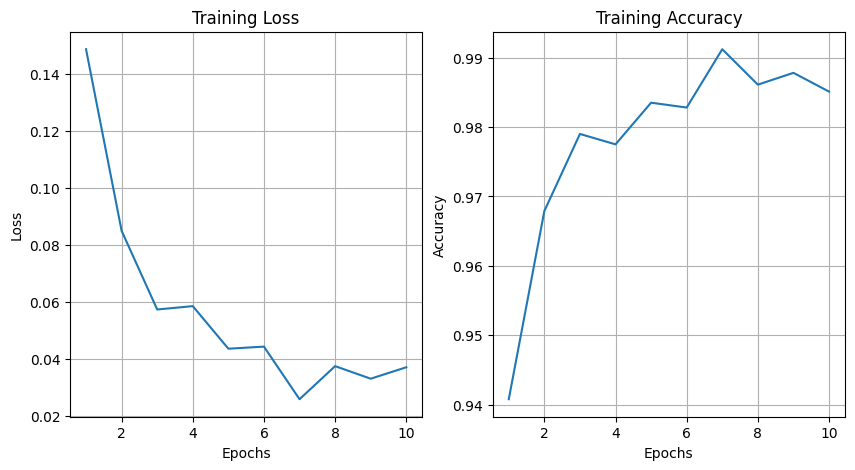

In [ ]:
# --------------------------------
# PART C
# --------------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

plt.show()


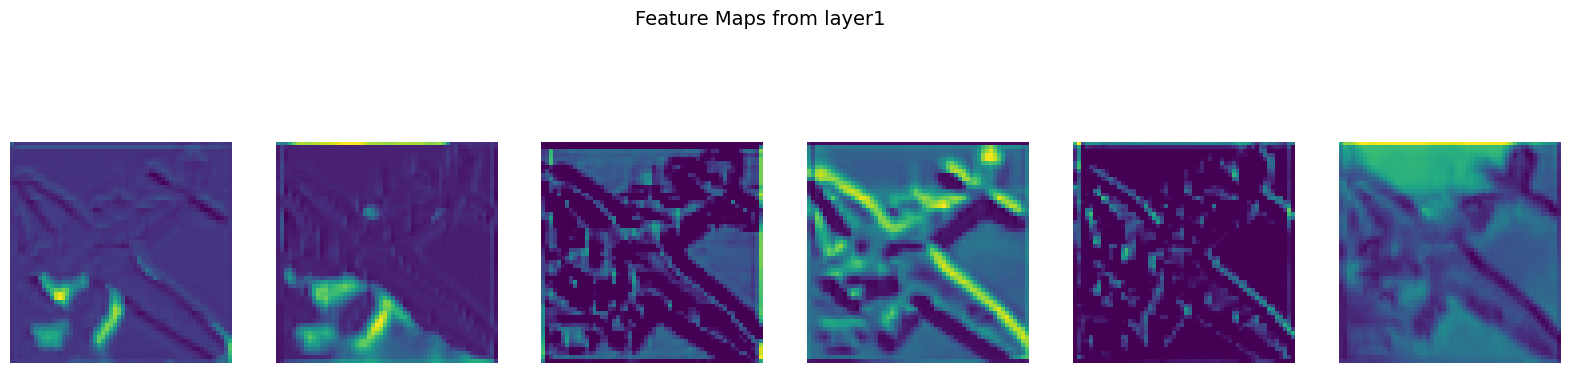

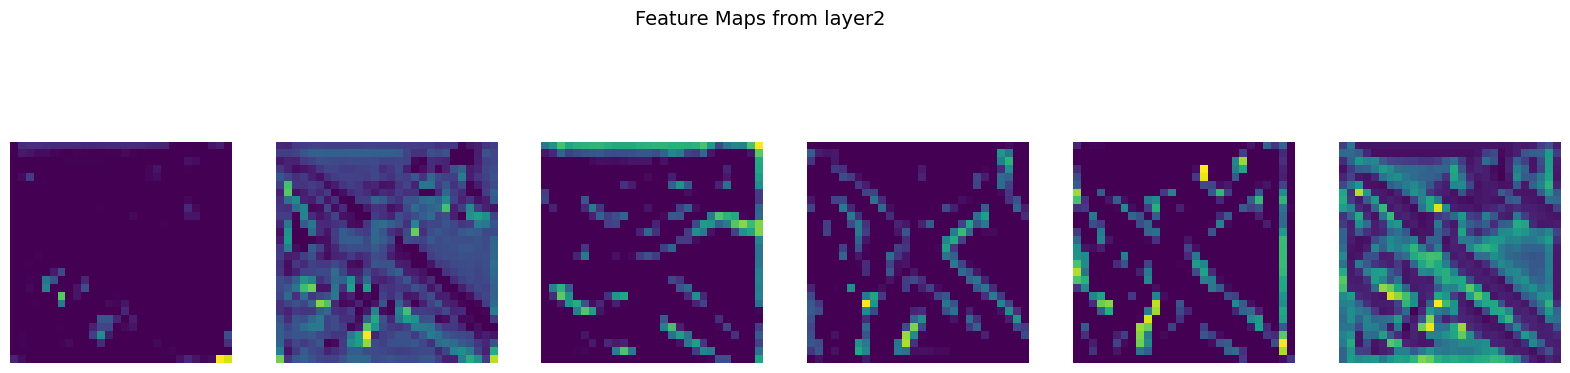

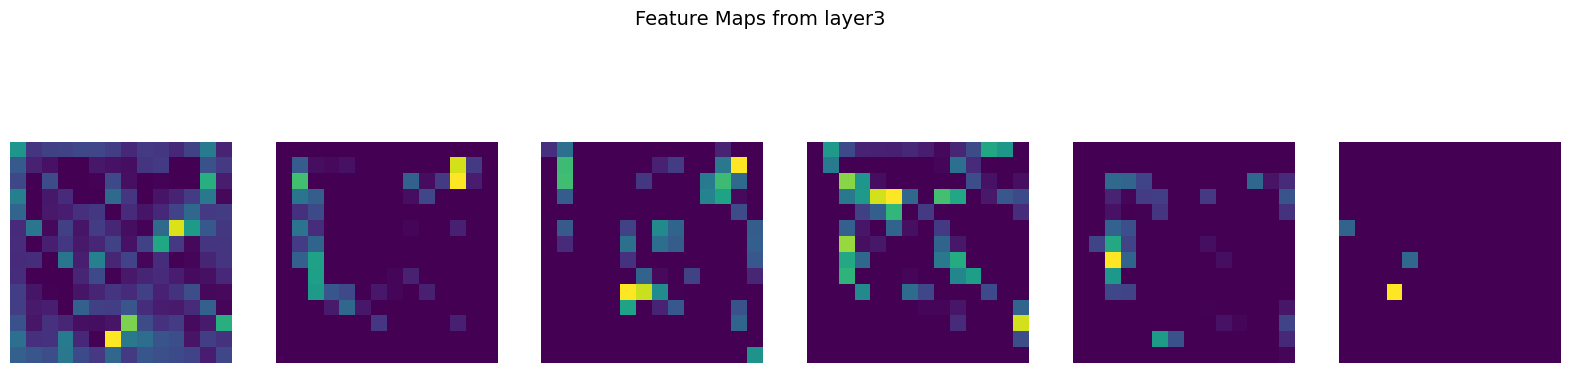

In [ ]:
# --------------------------------
# PART D
# --------------------------------
def get_feature_maps(model, layer_names, input_image):
    feature_maps = {}

    def hook(module, input, output, layer_name):
        feature_maps[layer_name] = output.detach().cpu()

    hooks = []
    for layer_name in layer_names:
        hooks.append(getattr(model, layer_name).register_forward_hook(
            lambda m, i, o, ln=layer_name: hook(m, i, o, ln)))

    model.eval()
    with torch.no_grad():
        model(input_image.unsqueeze(0).to(device))

    for hook_handle in hooks:
        hook_handle.remove()

    return feature_maps

# Visualizing Feature Maps
sample_image, _ = testset[5]
sample_image = sample_image.to(device)

layer_names = ['layer1', 'layer2', 'layer3']  # Main layers in ResNet50
feature_maps = get_feature_maps(model, layer_names, sample_image)

for layer_name, fmap in feature_maps.items():
    num_channels = fmap.shape[1]
    fig, axs = plt.subplots(1, 6, figsize=(20, 5))
    fig.suptitle(f'Feature Maps from {layer_name}', fontsize=14)

    for i in range(6):
        axs[i].imshow(fmap[0, i].numpy(), cmap='viridis')
        axs[i].axis('off')
    plt.show()



#### Part 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import random
import matplotlib.pyplot as plt

# --------------------------------
# PART A: Optimized TripletDataset
# --------------------------------

class TripletDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

        # Precomputing indices for each label for efficient sampling
        self.label_to_indices = {}
        for idx, (_, label) in enumerate(dataset):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]

        # Positive sample
        positive_idx = random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.dataset[positive_idx]

        # Negative sample
        negative_label = random.choice([l for l in self.label_to_indices if l != anchor_label])
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_idx]

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

In [ ]:
# --------------------------------
# PART B: TripletNet and Loss
# --------------------------------

class TripletNet(nn.Module):
    def __init__(self, base_model):
        super(TripletNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer
        self.flatten = nn.Flatten()

    def forward(self, anchor, positive, negative):
        anchor_feat = self.flatten(self.base_model(anchor))
        positive_feat = self.flatten(self.base_model(positive))
        negative_feat = self.flatten(self.base_model(negative))
        return anchor_feat, positive_feat, negative_feat

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive, p=2)
        negative_distance = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(positive_distance - negative_distance + self.margin)
        return loss.mean()

In [ ]:
def train_triplet_network():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data and Transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True)
    triplet_dataset = TripletDataset(trainset, transform)
    train_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True, num_workers=4)

    # Model and Optimizer
    base_model = models.resnet50(pretrained=True)
    model = TripletNet(base_model).to(device)
    criterion = TripletLoss(margin=1.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop
    epochs = 5
    losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_triplets = 0
        total_triplets = 0

        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Forward pass
            anchor_feat, positive_feat, negative_feat = model(anchor, positive, negative)
            loss = criterion(anchor_feat, positive_feat, negative_feat)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            pos_dist = torch.norm(anchor_feat - positive_feat, dim=1)
            neg_dist = torch.norm(anchor_feat - negative_feat, dim=1)
            correct_triplets += (pos_dist < neg_dist).sum().item()
            total_triplets += anchor.size(0)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        epoch_accuracy = correct_triplets / total_triplets
        accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Plotting Loss and Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss for Triplet Network')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies, label='Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy for Triplet Network')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


100%|██████████| 170M/170M [00:05<00:00, 31.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch [1/5], Loss: 0.5791, Accuracy: 0.7526
Epoch [2/5], Loss: 0.4515, Accuracy: 0.8063
Epoch [3/5], Loss: 0.3921, Accuracy: 0.8337
Epoch [4/5], Loss: 0.3459, Accuracy: 0.8546
Epoch [5/5], Loss: 0.3069, Accuracy: 0.8724


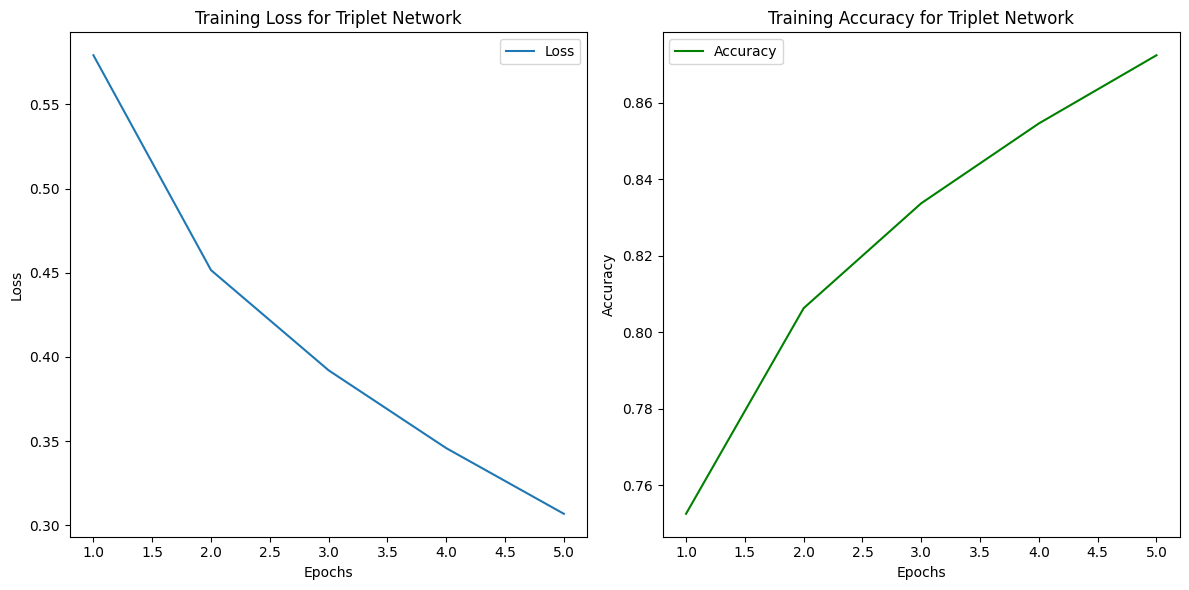

In [ ]:
if __name__ == "__main__":
    trained_model = train_triplet_network()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np


class FullModel(nn.Module):
    def __init__(self, feature_extractor, num_classes=2):
        super(FullModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Ensure the output size is [batch_size, 2048, 1, 1]
        self.fc = nn.Linear(2048, num_classes)    # ResNet50 feature size is 2048

    def forward(self, x):
        x = self.feature_extractor(x)            # Pass through the feature extractor
        x = self.pool(x)                         # Adaptive pooling to reduce spatial dimensions
        x = x.view(x.size(0), -1)                # Flatten to [batch_size, 2048]
        x = self.fc(x)                           # Fully connected layer for classification
        return x


def fine_tune_with_full_model(trained_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extracting the feature extractor (base_model) from the trained TripletNet
    feature_extractor = nn.Sequential(*list(trained_model.base_model.children())[:-1])  # Remove the original FC layer

    # Defining the new full model
    full_model = FullModel(feature_extractor).to(device)

    # Freezing feature extractor weights
    for param in full_model.feature_extractor.parameters():
        param.requires_grad = False

    # Data Preparation (airplane and automobile only)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Filtering out only airplane (label=0) and automobile (label=1)
    train_indices = [i for i, label in enumerate(trainset.targets) if label in [0, 1]]
    test_indices = [i for i, label in enumerate(testset.targets) if label in [0, 1]]

    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=4)


    optimizer = optim.Adam(full_model.fc.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Fine-tuning Loop
    epochs = 5
    losses=[]
    accs=[]
    for epoch in range(epochs):
        full_model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = (labels == 1).long()  # Map labels to 0 (airplane) and 1 (automobile)

            # Forward pass
            outputs = full_model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracy = correct / total
        accs.append(accuracy)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


    # Plotting Loss and Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss For Classifier')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accs, label='Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy For Classifier')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluating on Test Data
    full_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = (labels == 1).long()

            outputs = full_model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {correct / total:.4f}")
    return full_model




Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Loss: 0.3218, Accuracy: 0.8758
Epoch [2/5], Loss: 0.2227, Accuracy: 0.9102
Epoch [3/5], Loss: 0.1939, Accuracy: 0.9236
Epoch [4/5], Loss: 0.1935, Accuracy: 0.9206
Epoch [5/5], Loss: 0.1862, Accuracy: 0.9284


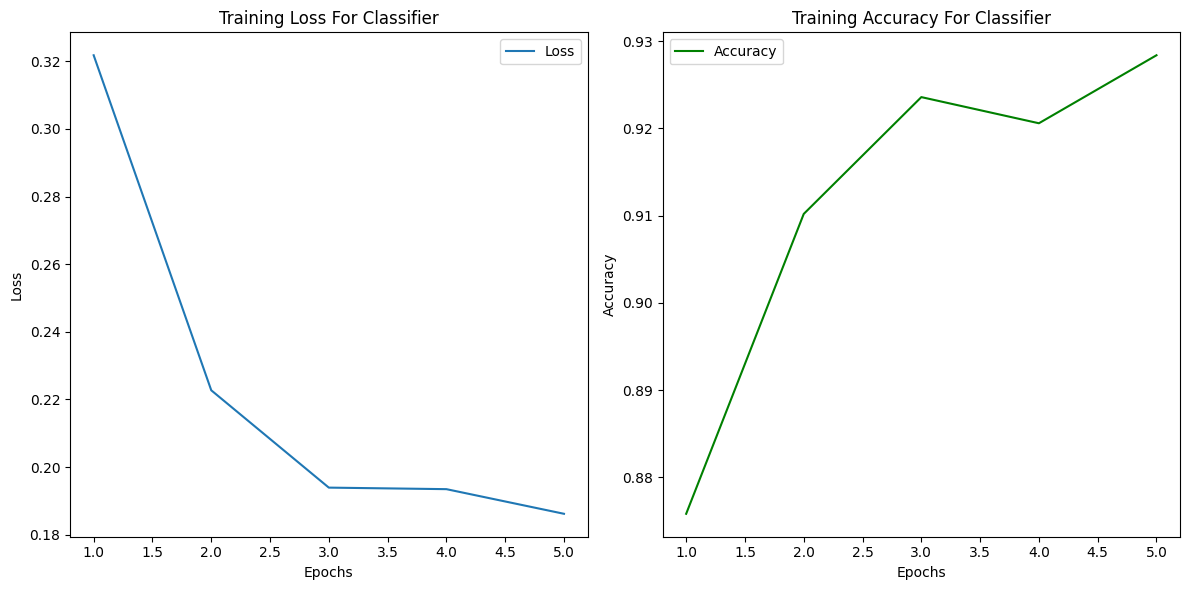

Test Accuracy: 0.9275


In [ ]:
if __name__ == "__main__":
    fine_tuned_model = fine_tune_with_full_model(trained_model)

In [ ]:
import matplotlib.pyplot as plt

# Function to Register Hooks
def register_hooks(model, layers_to_hook):
    feature_maps = {}

    def hook_fn(module, input, output, layer_name):
        feature_maps[layer_name] = output.detach()

    hooks = []
    for name, layer in model.named_modules():
        if name in layers_to_hook:
            hook = layer.register_forward_hook(
                lambda module, input, output, layer_name=name: hook_fn(module, input, output, layer_name)
            )
            hooks.append(hook)
    return feature_maps, hooks

# Function to Visualize Feature Maps
def visualize_feature_maps(feature_maps, title_prefix="Feature Maps"):
    for layer_name, feature_map in feature_maps.items():
        # Visualize up to 6 feature maps (channels)
        num_maps = min(6, feature_map.shape[1])
        fig, axs = plt.subplots(1, num_maps, figsize=(15, 5))
        fig.suptitle(f"{title_prefix} from {layer_name}", fontsize=16)

        for i in range(num_maps):
            axs[i].imshow(feature_map[0, i].cpu(), cmap="viridis")
            axs[i].axis("off")
            axs[i].set_title(f"Map {i+1}")
        plt.show()

# Function to Visualize Feature Maps from a Sample Image
def visualize_triplet_feature_maps(model, sample_image, layers_to_hook, device):
    model.eval()
    with torch.no_grad():
        # Register hooks
        feature_maps, hooks = register_hooks(model.feature_extractor, layers_to_hook)

        # Adding batch dimension and move to device
        sample_image = sample_image.unsqueeze(0).to(device)
        _ = model(sample_image)  # Forward pass through the full model

        # Visualize captured feature maps
        visualize_feature_maps(feature_maps, title_prefix="Triplet Loss Trained")

        # Remove hooks
        for hook in hooks:
            hook.remove()



Files already downloaded and verified
Files already downloaded and verified


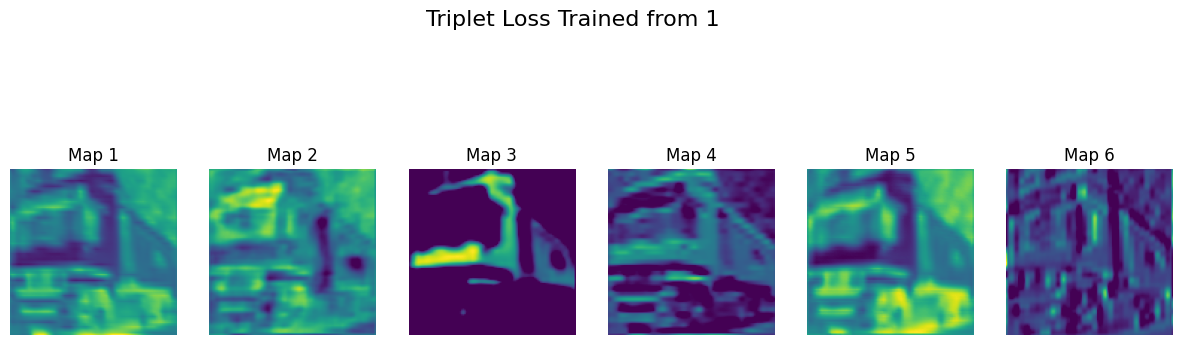

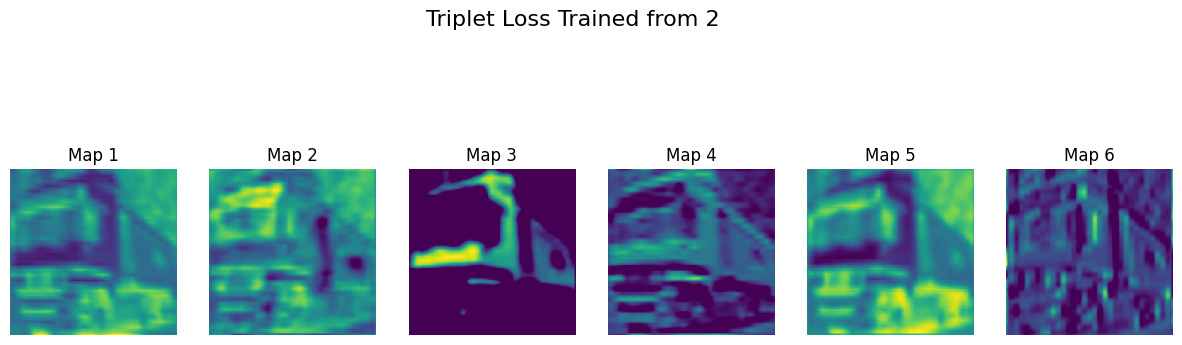

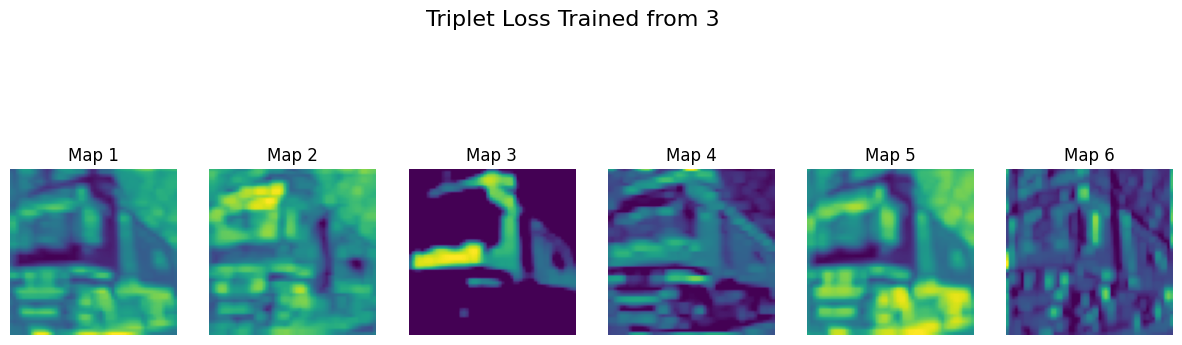

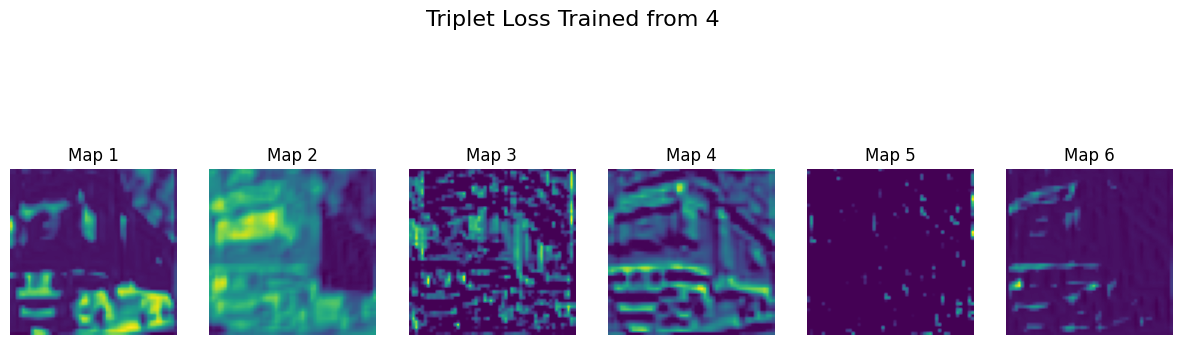

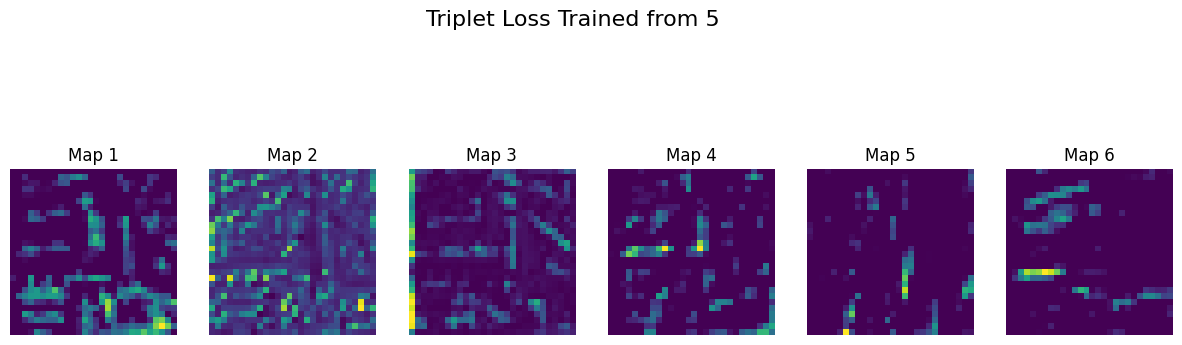

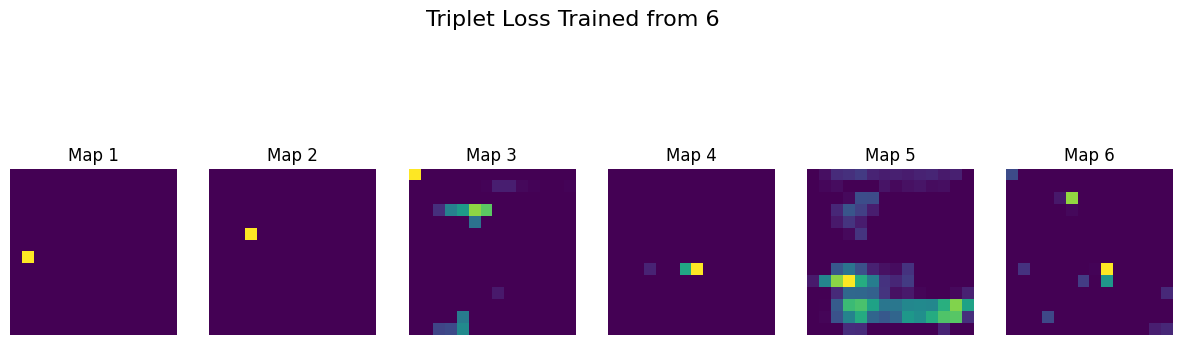

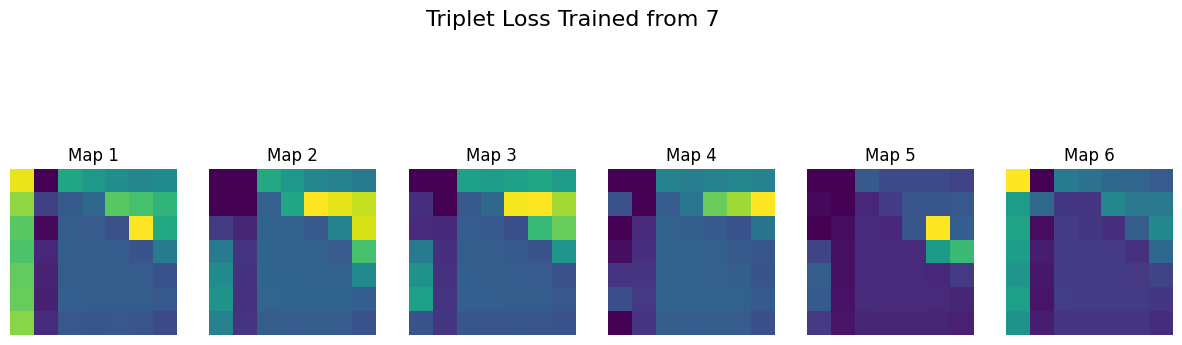

In [ ]:
# Sample Usage
if __name__ == "__main__":


    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    sample_image, _ = trainset[1]  # sample_image is already a Tensor

    # Layers to hook
    layers_to_hook = ['1', '2', '3', '4', '5', '6', '7']


    # Visualize feature maps
    visualize_triplet_feature_maps(fine_tuned_model, sample_image, layers_to_hook, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

**Feature maps of the previous part:**

The network is pretrained on ImageNet, which provides strong, general feature extraction capabilities. In the initial layers, the feature maps highlight edges, textures, and basic shapes, while deeper layers specialize in classifying objects.
These pretrained filters allow the model to adapt relatively quickly to CIFAR-10, even for the two target classes (airplane and automobile), as the convolutional layers already capture rich and high-quality features.

As training progresses using Cross Entropy Loss, the feature maps gradually focus on regions relevant to the target classes. The network fine-tunes its filters to distinguish airplanes and automobiles based on discriminative regions such as wings, body shape, or edges.
However, since Cross Entropy Loss focuses on optimizing class prediction, the network sometimes over-relies on generic textures and local features rather than forming clear, structured representations of the objects.

The feature maps appear noisy and cluttered because the model activates on diverse spatial regions to maximize classification accuracy.
There is less focus on the overall object structure (e.g., airplane shape or car outline) and more emphasis on smaller, localized patterns that contribute to distinguishing classes.



**Feature maps of this part:**

In this part, the network learns feature embeddings using Triplet Loss, which optimizes the model to maximize inter-class distance (separating dissimilar classes) and minimize intra-class distance (clustering similar classes).
Unlike the pretrained model, the feature extractor here starts with less robust filters (e.g., initialized randomly) and must learn meaningful features directly from the CIFAR-10 dataset.

During the triplet loss training phase, the feature maps may initially appear less focused and less class-discriminative compared to the pretrained ResNet feature maps. This is because the network is learning the features from scratch without leveraging pre-existing pretrained filters.

As training progresses, the triplet loss gradually optimizes the network to learn structured and discriminative features that are useful for distinguishing airplanes and automobiles. The learned feature maps begin to highlight object-specific structures such as:
Airplane: T-shaped wings, fuselage shape.
Automobile: Rectangular body, wheels.
The feature maps become cleaner and smoother, focusing on regions relevant to the object’s overall shape rather than generic textures.

The triplet loss ensures that the feature maps emphasize the global structure of the objects rather than noisy textures.
Compared to the first image, these feature maps appear less noisy and more focused, clearly representing the object’s shape and class-specific regions.



#### Part3

### **1. Feature Map Quality in Different Layers of the Network**

#### **Cross Entropy Loss (CE):**  
   - In pretrained networks (e.g., ResNet, VGG), initial layers extract low-level features such as edges, textures, and shapes. These features are already robust due to prior ImageNet training.  
   - CE loss drives deeper layers to focus on class-specific discriminative regions (e.g., airplane wings or car wheels).  
   - Feature maps may emphasize localized regions that directly maximize classification accuracy. This often leads to overfitting to training data textures or biases.    
   - While effective for classification, the feature maps appear noisy, with fine-grained emphasis on patterns instead of the holistic object structure.  

#### **Triplet Loss:**
   - Initially, triplet loss encourages the model to build discriminative embeddings, meaning that the focus starts on general patterns like global shapes and coarse features.   
   - As training progresses, deeper layers refine these embeddings to maximize inter-class distance (airplane vs car) and minimize intra-class distance(grouping same-class samples).  
   - The feature maps are more global and focused on entire object structures, like the outline of airplanes or cars.  
   - The feature maps are cleaner and smoother compared to CE loss, with less noise and a better ability to generalize to unseen data.  

---

### **2. Final Accuracy of the Model on the Test Data**

#### **Cross Entropy Loss (CE):**
- CE loss directly optimizes for classification accuracy, leading to fast convergence and excellent performance on the training and test data.   
- Reaches 99.12% by epoch 7, showing strong learning of the training dataset.  
- High test accuracy is typical when the dataset is small and well-defined, as CE loss fine-tunes pretrained networks effectively.   
- CE loss may fail to generalize well when exposed to unseen or distinct data due to overfitting on the target dataset.

#### **Triplet Loss:**
- Training accuracy progresses more slowly (e.g., 87.24% by Epoch 5) because triplet loss optimizes embeddings rather than directly classifying inputs.
- Test accuracy is strong at 92.75%, demonstrating that triplet loss produces robust and generalizable features.
- The embeddings learned by triplet loss perform well because they create a well-separated feature space, where similar objects (e.g., airplanes) are clustered, and dissimilar objects (e.g., automobiles) are separated.
- Triplet loss generalizes better to unseen data or tasks (e.g., clustering, retrieval) because of its focus on creating robust embeddings.

---

### **3. Convergence Speed of the Model During Training**

#### **Cross Entropy Loss (CE):**
- CE loss achieves rapid convergence, especially when using pretrained models. This is because:  
- The network fine-tunes well-established feature extractors.  
- The optimization objective (minimizing classification error) is straightforward.   
- Accuracy reaches 99.12% by epoch 7, showing rapid improvement and stabilization.  
- CE loss is computationally efficient and quickly achieves high accuracy.

#### **Triplet Loss:**
- Triplet loss  converges slower because it optimizes for embedding space relationships (distance between anchor, positive, and negative samples).
Learning meaningful embeddings takes longer and requires careful triplet sampling.
- Training accuracy is slower to improve (87.24% by Epoch 5), but the resulting test accuracy (92.75%) is robust, showing the benefits of a well-learned embedding space.
- Triplet loss requires more training epochs and computational resources but delivers embeddings that are transferable to other tasks.  

---


### **Application Recommendations:**  

1. **Cross Entropy Loss:**  
    We should use CE loss when:  
     - We want to maximize classification accuracy on a specific dataset.  
     - Small, well-labeled, and well-defined datasets like CIFAR-10.  
     - When rapid convergence and computational efficiency are important.  
     - For example: Object classification, basic computer vision tasks, and image categorization.  

2. **Triplet Loss:**  
   We should use triplet loss when:  
     - We want to build robust, generalizable feature embeddings.  
     - Complex, high-variance, or unseen datasets.  
     - Feature extraction, object retrieval, clustering, face verification, and tasks requiring similarity-based classification.  
     - For example:
      - Image retrieval (finding visually similar images).  
      - Face recognition (matching individuals in a database).  
      - Open-set classification where new classes may appear.  



#### Part 4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from torchvision import datasets, models, transforms
from PIL import Image
import random


class TripletDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.data = self.subset.dataset.data[self.subset.indices]
        self.targets = np.array(self.subset.dataset.targets)[self.subset.indices]
        self.transform = transform

        self.labels_set = set(self.targets)
        self.label_to_indices = {label: np.where(self.targets == label)[0] for label in self.labels_set}

    def __getitem__(self, index):
        anchor_img = self.data[index]
        anchor_label = self.targets[index]

        # Positive example
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        positive_img = self.data[positive_index]

        # Negative example
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = np.random.choice(list(self.labels_set - {anchor_label}))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        negative_img = self.data[negative_index]

        anchor_img = Image.fromarray(anchor_img)
        positive_img = Image.fromarray(positive_img)
        negative_img = Image.fromarray(negative_img)

        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

    def __len__(self):
        return len(self.subset)


weights = models.ResNet50_Weights.DEFAULT
transform = weights.transforms()

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_indices = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1]]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1]]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

triplet_train_dataset = TripletDataset(train_subset, transform=transform)
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

class FullModel(nn.Module):
    def __init__(self, base_model, embedding_dim=2048, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Removing fc layer
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten
        embeddings = x
        logits = self.fc(x)
        return embeddings, logits

# Initializing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = models.resnet50(weights=weights)
model = FullModel(base_model, embedding_dim=2048, num_classes=2).to(device)

triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 5
train_losses = []
train_ce_losses = []
train_triplet_losses = []
train_accs = []

for epoch in range(num_epochs):
    model.train()
    curr_loss = 0.0
    curr_ce_loss = 0.0
    curr_triplet_loss = 0.0
    correct = 0
    total = 0

    for anchor, positive, negative, anchor_label in triplet_train_loader:
        anchor, positive, negative, anchor_label = anchor.to(device), positive.to(device), negative.to(device), anchor_label.to(device)

        optimizer.zero_grad()
        # Forward pass
        anchor_emb, anchor_logits = model(anchor)
        positive_emb, _ = model(positive)
        negative_emb, _ = model(negative)

        # Combining the losses
        trip_loss = triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
        ce_loss = ce_loss_fn(anchor_logits, anchor_label)
        loss = trip_loss + ce_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        curr_loss += loss.item()
        curr_ce_loss += ce_loss.item()
        curr_triplet_loss += trip_loss.item()

        _, predicted = anchor_logits.max(1)
        total += anchor_label.size(0)
        correct += (predicted == anchor_label).sum().item()

    epoch_loss = curr_loss / len(triplet_train_loader)
    epoch_ce_loss = curr_ce_loss / len(triplet_train_loader)
    epoch_trip_loss = curr_triplet_loss / len(triplet_train_loader)
    epoch_acc = 100.0 * correct / total

    train_losses.append(epoch_loss)
    train_ce_losses.append(epoch_ce_loss)
    train_triplet_losses.append(epoch_trip_loss)
    train_accs.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Total Loss: {epoch_loss:.4f} "
          f"(CE: {epoch_ce_loss:.4f}, Triplet: {epoch_trip_loss:.4f}) "
          f"Train Acc: {epoch_acc:.2f}%")


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


Epoch [1/5] Total Loss: 0.3088 (CE: 0.1425, Triplet: 0.1664) Train Acc: 96.22%
Epoch [2/5] Total Loss: 0.0591 (CE: 0.0247, Triplet: 0.0344) Train Acc: 99.27%
Epoch [3/5] Total Loss: 0.0427 (CE: 0.0183, Triplet: 0.0244) Train Acc: 99.48%
Epoch [4/5] Total Loss: 0.0221 (CE: 0.0093, Triplet: 0.0128) Train Acc: 99.72%
Epoch [5/5] Total Loss: 0.0233 (CE: 0.0098, Triplet: 0.0135) Train Acc: 99.73%


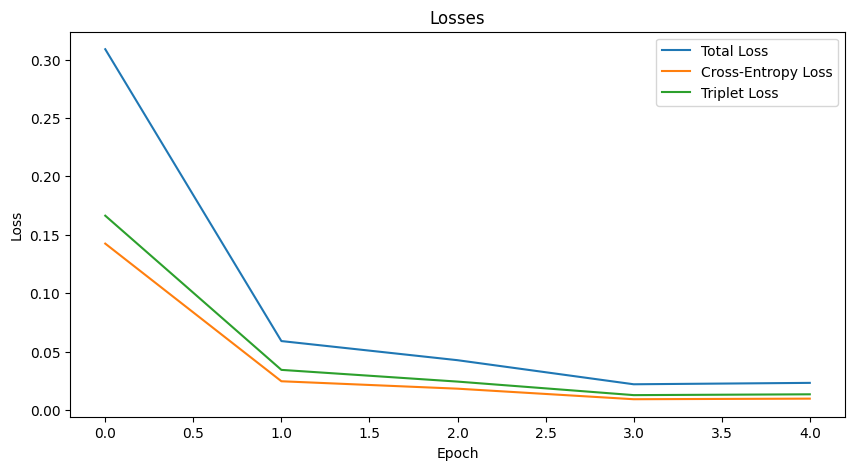

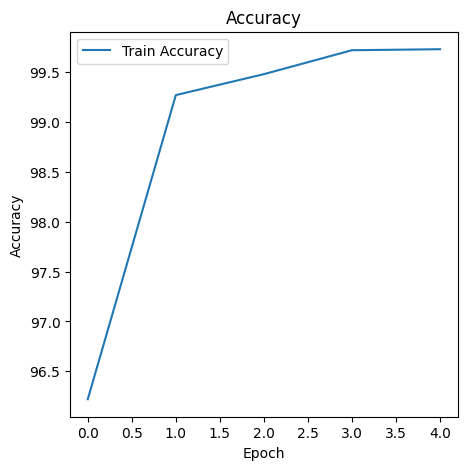

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Total Loss')
plt.plot(train_ce_losses, label='Cross-Entropy Loss')
plt.plot(train_triplet_losses, label='Triplet Loss')
plt.legend()
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = (labels == 1).long()

        _, logits = model(images)
        _, predicted = logits.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.9975



By combining the Cross Entropy Loss and Triplet Loss into a single total loss $ L_{\text{total}} = L_{\text{CE}} + L_{\text{triplet}} $, the model benefits from both objectives, leading to synergistic improvements in performance.

 The combined loss ensures that the feature extractor learns robust, generalizable embeddings while the classifier achieves high accuracy.  
The CE loss ensures the decision boundaries are accurate and precise, while the triplet loss refines the feature space, reducing intra-class variability and increasing inter-class separation.  


---

#### **Effect on Final Accuracy**

The combination of the two losses improves the overall model accuracy significantly:  
- Train Accuracy: 99.73% at epoch 5.  
- Test Accuracy: 99.75%.  
  
Cross Entropy Loss excels at fitting the training data to the labels and achieving high accuracy.  
Triplet Loss adds regularization to the learning process by forcing the model to learn more generalizable representations.  
As a result, the classifier can perform better on the test set, as the feature extractor produces embeddings that generalize beyond the training data.  

---

#### **Effect on Convergence Speed**

Training the model with the combined loss still achieves rapid convergence:  
- By Epoch 2, the train accuracy is already 99.27%.  
- This shows that CE loss continues to guide the network toward fast convergence.  

- Cross Entropy Loss provides a strong optimization signal that ensures rapid improvement in classification performance.  
- Triplet Loss acts as a refinement rather than a standalone objective. It fine-tunes the feature space during training without significantly slowing down the convergence.  

Compared to training with Triplet Loss alone, where convergence is slower, combining the two losses accelerates learning while still achieving high-quality embeddings.  

---

#### **Benefits of using the combination**

1. CE Loss Provides Fast Optimization:
   - It drives the classifier to achieve high accuracy quickly by learning precise decision boundaries.

2. Triplet Loss Improves Embedding Quality:  
   - It refines the feature extractor to ensure the learned representations are well-separated and generalizable.

3. Regularization Effect:  
   - Triplet Loss acts as an implicit regularizer, preventing the model from overfitting to the training data, which boosts test accuracy.

4. Balanced Learning:
   - The two losses complement each other: one optimizes for accuracy, and the other optimizes for feature quality.

